In [1]:
import cv2
import mediapipe as mp
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import clear_output, display, Image
import time

In [2]:
def calculate_angle(a, b, c):
    """
    Calculate the angle between three points.
    a, b, c should be arrays or lists with [x, y] coordinates.
    b is the vertex point.
    Returns the angle in degrees.
    """
    a = np.array(a)
    b = np.array(b)
    c = np.array(c)
    
    # Calculate the angle in radians and convert to degrees.
    radians = np.arctan2(c[1] - b[1], c[0] - b[0]) - np.arctan2(a[1] - b[1], a[0] - b[0])
    angle = np.abs(radians * 180.0 / np.pi)
    
    # Ensure angle is within [0, 180]
    if angle > 180.0:
        angle = 360 - angle
        
    return angle


In [3]:
# Initialize MediaPipe Pose solution and drawing utilities.
mp_pose = mp.solutions.pose
pose = mp_pose.Pose(min_detection_confidence=0.5, min_tracking_confidence=0.5)
mp_draw = mp.solutions.drawing_utils

# Path to the squat video file.
video_path = "max_squat_video.mp4"  # Update this path as needed.


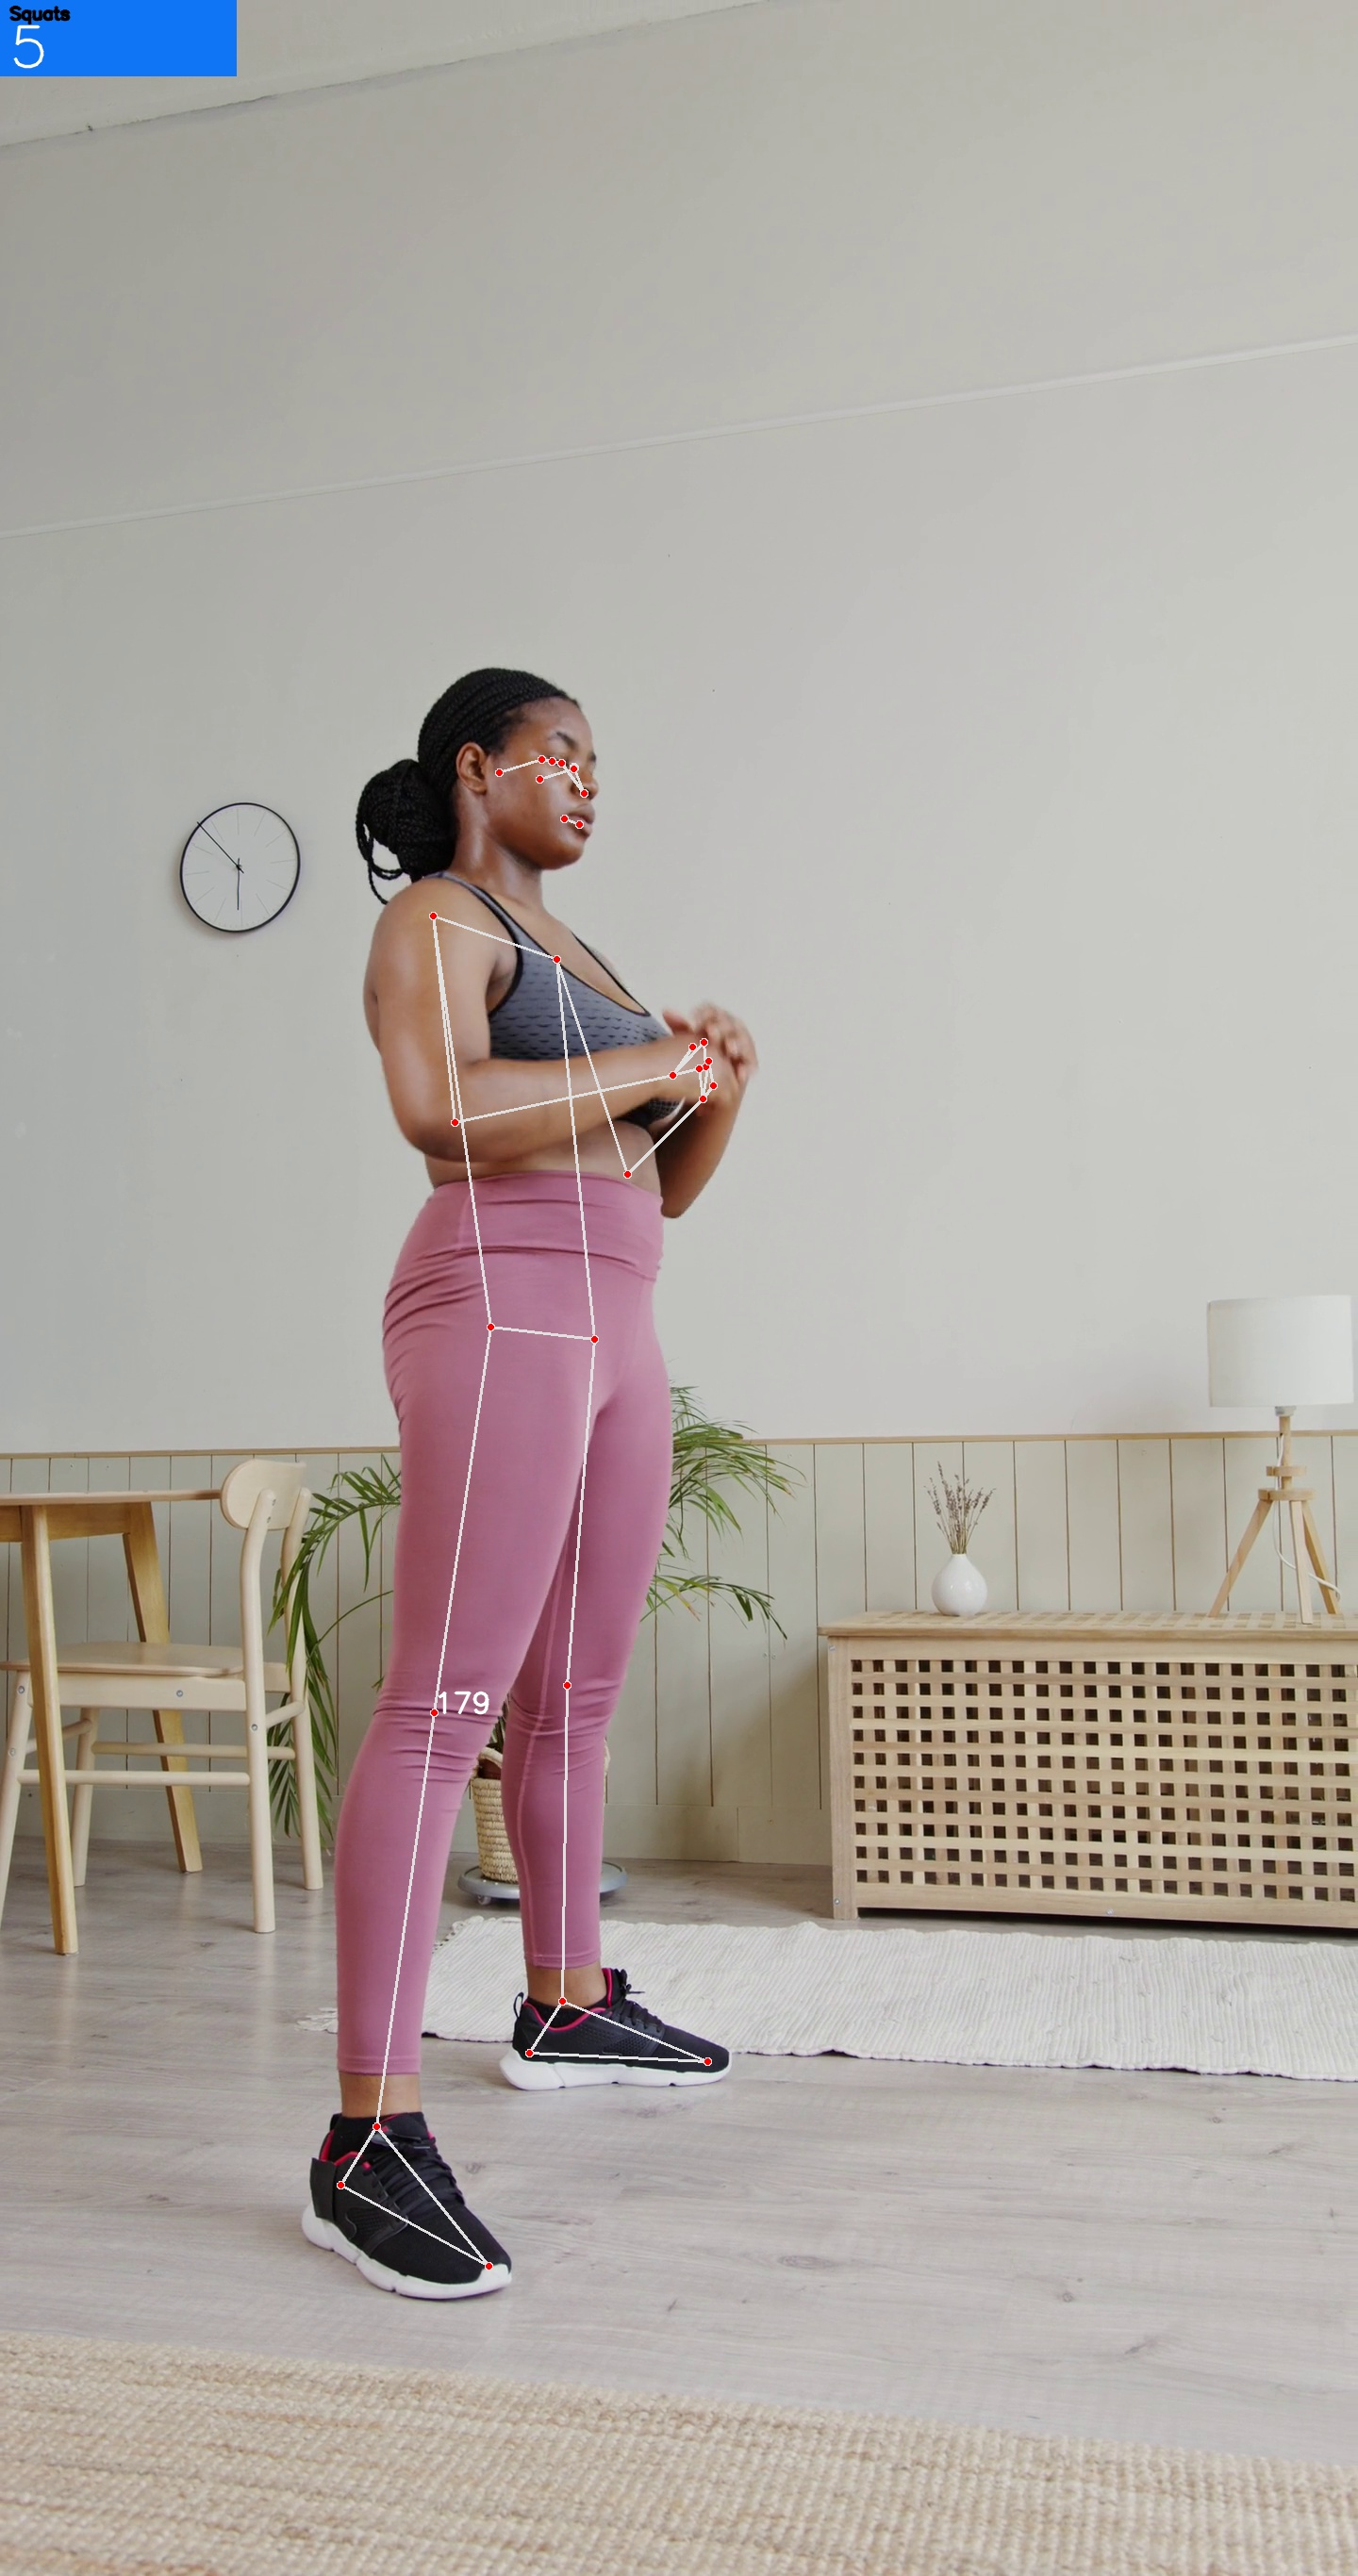

Squat Count: 5
Video processing complete!


In [6]:
# Open the video using OpenCV.
cap = cv2.VideoCapture(video_path)
if not cap.isOpened():
    print("Error opening video file!")
    exit()

# Retrieve the video's FPS (frames per second) for proper playback speed.
fps = cap.get(cv2.CAP_PROP_FPS)

# Initialize squat counting variables.
squat_count = 0
stage = "up"  # Assume the person starts in the standing ("up") position.

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break  # End of video.
    
    # ----- Step 1: Preprocess the Frame -----
    # Convert the frame from BGR to RGB (MediaPipe requires RGB).
    image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    image.flags.writeable = False  # Improve performance.
    results = pose.process(image)
    image.flags.writeable = True
    # Convert the frame back to BGR for display.
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    
    # ----- Step 2: Extract Landmarks and Compute the Knee Angle -----
    try:
        landmarks = results.pose_landmarks.landmark
        
        # Extract coordinates for the right hip, knee, and ankle.
        hip = [landmarks[mp_pose.PoseLandmark.RIGHT_HIP.value].x,
               landmarks[mp_pose.PoseLandmark.RIGHT_HIP.value].y]
        knee = [landmarks[mp_pose.PoseLandmark.RIGHT_KNEE.value].x,
                landmarks[mp_pose.PoseLandmark.RIGHT_KNEE.value].y]
        ankle = [landmarks[mp_pose.PoseLandmark.RIGHT_ANKLE.value].x,
                 landmarks[mp_pose.PoseLandmark.RIGHT_ANKLE.value].y]
        
        # Calculate the knee angle.
        angle = calculate_angle(hip, knee, ankle)
        
        # Convert normalized coordinates to pixel values for annotation.
        h, w, _ = image.shape
        knee_pixel = tuple(np.multiply(knee, [w, h]).astype(int))
        cv2.putText(image, str(int(angle)),
                    knee_pixel,
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)
        
        # ----- Squat Counting Logic -----
        
        # When the knee angle exceeds 160° (standing up) and the previous stage was "down",
        # count one squat and reset the stage to "up."
        if angle > 160:
            if stage == "down":
                squat_count += 1
                stage = "up"
        
         # When the knee angle is less than 90°, assume the person is in the "down" position.
        elif angle < 90:
            if stage != "down":
                stage = "down"       
    except Exception as e:
        # If no landmarks are detected, skip this frame.
        pass

    # ----- Step 3: Annotate the Frame -----
    # Draw a rectangle overlay for the squat count.
    cv2.rectangle(image, (0, 0), (250, 80), (245, 117, 16), -1)
    cv2.putText(image, 'Squats', (10, 20),
                cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 0, 0), 2, cv2.LINE_AA)
    cv2.putText(image, str(squat_count),
                (10, 70),
                cv2.FONT_HERSHEY_SIMPLEX, 2, (255, 255, 255), 2, cv2.LINE_AA)
    
    # Draw the pose landmarks for visual feedback.
    if results.pose_landmarks:
        mp_draw.draw_landmarks(image, results.pose_landmarks, mp_pose.POSE_CONNECTIONS)
        
    # ----- Step 4: Display the Frame in Real Time -----
    ret2, buffer = cv2.imencode('.jpg', image)
    if not ret2:
        continue  # Skip frame if encoding fails.
    
    clear_output(wait=True)
    display(Image(data=buffer.tobytes()))
    print("Squat Count:", squat_count)
    
    # Wait briefly to match the video's FPS for smooth playback.
    time.sleep(1 / fps)

# Release the video capture resource.
cap.release()
print("Video processing complete!")